In [1]:
#To do lambdaの外部入力
using Plots
using LinearAlgebra
using Revise
using Optim
#using FFTW
using Zygote
using Nevanlinna
using LaTeXStrings
using MultiFloats
using SparseIR
#using DoubleFloats

┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1423
┌ Warning: Package ChainRules does not have Distributed in its dependencies:
│ - If you have ChainRules checked out for development and have
│   added Distributed as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ChainRules
└ Loading Distributed into ChainRules from project dependency, future warnings for ChainRules are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
│   exception = ErrorException("Required dependency ChainRules [082447d4-558c-5d27-93f4-14fc19e9eca2] failed to load from a cache file.")
└ @ Base loading.jl:1132
┌ Info: Precompiling ChainRules [082447d4-558c-5d27-93f4-14fc19e9eca2]
└ @ Base loading.jl:1423
┌ Warning: Package ChainRules does not have Distributed in its dependencies:

In [2]:
# Set work data Type
#T = Float64x2
T = BigFloat

BigFloat

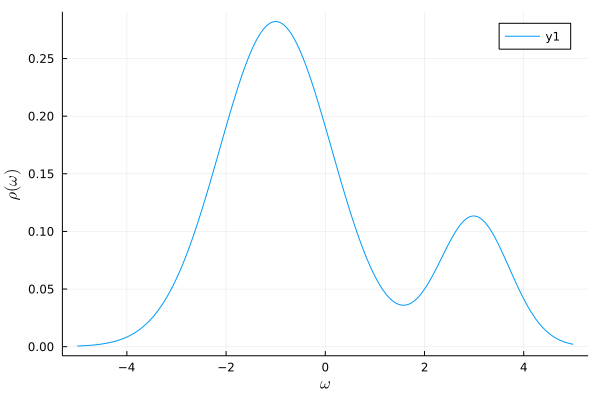

In [3]:
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
lorentzian(x, mu, gamma) = gamma/(pi*(gamma^2+(x-mu)^2))

#on-centered gaussian 23s
#rho(omega) = gaussian(omega, 0.0, 0.15)  

#on-centered lorentzian 2340s
#rho(omega) = lorentzian(omega, 0.0, 0.15)  

#two peak model 4403s
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)

#rho(omega) = 0.8*lorentzian(omega, -1.0, 1.6) + 0.2*lorentzian(omega, 3, 1)

#three peak model 1255s
#rho(omega) = 0.4*gaussian(omega, 1.0, 0.5) + 
#    0.4*gaussian(omega, 3.0, 0.8) + 0.2*gaussian(omega, -2.0, 1.0) 

# Hubbard gap 2619s
#rho(omega) = 0.5*gaussian(omega, -3.0, 1.0) + 0.5*gaussian(omega, 3.0, 1.0) 

omegas = LinRange(-5, 5, 1000)
#plt.xlabel(L"\omega")
#plt.ylabel(L"\rho(\omega)")
#plt.plot(omegas, rho.(omegas))
plot(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
setprecision(512)
;

In [5]:
beta = 10
wmax = 10
IR_basis_set = FiniteTempBasisSet(Float64(beta), Float64(wmax), 1e-15) #もともと-7
#basis = FiniteTempBasis(fermion, beta, wmax, 1e-7)

rhol = [overlap(IR_basis_set.basis_f.v[l], rho) for l in 1:length(IR_basis_set.basis_f)]
gl = - IR_basis_set.basis_f.s .* big.(rhol)
;

In [6]:
#off-centered delta function
#rhol = (IR_basis_set.basis_f.v(0.2))
#gl = - IR_basis_set.basis_f.s .* rhol
;

In [7]:
gw = evaluate(IR_basis_set.smpl_wn_f, gl)
hnw = length(IR_basis_set.smpl_wn_f.sampling_points)÷2

22

In [8]:
test_gw   = Array{Complex{T}}(undef, hnw) 
test_smpl = Array{Complex{T}}(undef, hnw) 
;

In [9]:
for i in 1:hnw
    test_smpl[i]= im*IR_basis_set.smpl_wn_f.sampling_points[hnw+i]*pi/beta
    test_gw[i]  = gw[hnw+i]
end

In [10]:
N_real    =  1000
omega_max =  10.0
eta       =  0.001
H_max     =  50
ab_coeff  = zeros(ComplexF64, 2*H_max) 
lambda    = 1e-5
iter_tol  = 1000
N_imag    =  Nevanlinna.calc_opt_N_imag(hnw, test_smpl, test_gw)
#N_imag = 38
println("N_imp $(N_imag)")
;

N_imag is setted as 17
N_imp 17


In [11]:
@time sol = Nevanlinna.NevanlinnaSolver(N_imag, test_smpl, test_gw, N_real, omega_max, eta, H_max, iter_tol, lambda, true)
;

Pick matrix is positive semi-definite.
H=1
Iter     Function value   Gradient norm 
     0     1.854102e-03     7.641149e-03
 * time: 0.023590803146362305
     1     1.086594e-03     3.922548e-03
 * time: 2.4357378482818604
     2     8.760529e-04     5.953359e-03
 * time: 2.877987861633301
     3     4.684002e-04     1.126276e-03
 * time: 3.215247869491577
     4     4.329293e-04     6.935267e-05
 * time: 3.522859811782837
     5     4.327095e-04     7.522331e-06
 * time: 3.86670184135437
     6     4.327080e-04     9.750625e-07
 * time: 4.078341960906982
     7     4.327079e-04     6.594754e-08
 * time: 4.26785683631897
     8     4.327079e-04     3.771050e-09
 * time: 4.612290859222412
max_theta=0.175019067043355137519183361432134673846749739121913138473349881380920247164099419892364597623671641067427244287077646566927355086205637022712339034409148172
hardy optimization was success.
 63.832760 seconds (121.02 M allocations: 6.886 GiB, 5.28% gc time, 93.47% compilation time)


In [12]:
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     4.327079e-04     3.771050e-09
 * time: 0.0002110004425048828
max_theta=0.175019067043355137519183361432134673846749739121913138473349881380920247164099419892364597623671641067427244287077646566927355086205637022712339034409148172
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     4.327079e-04     3.483088e-03
 * time: 0.0002319812774658203
     1     3.411412e-04     2.284666e-03
 * time: 0.5026059150695801
     2     2.600365e-04     1.277972e-03
 * time: 1.183995008468628
     3     2.538532e-04     1.076369e-03
 * time: 1.6396608352661133
     4     1.805142e-04     4.009374e-04
 * time: 2.2792599201202393
     5     1.798424e-04     4.025252e-04
 * time: 2.633234977722168
     6     1.623496e-04     8.060983e-04
 * time: 3.2602508068084717
     7     1.248305e-04     1.128750e-04
 * time: 3.605417013168335
     8     1.237348e-04     3.102620e-05
 * time: 3.9585018157958984
     9     1.237

     9     5.770070e-06     4.665730e-05
 * time: 8.200366973876953
    10     5.625923e-06     4.698940e-05
 * time: 9.23500394821167
    11     5.210764e-06     3.744871e-05
 * time: 9.945052862167358
    12     5.194351e-06     3.876689e-05
 * time: 10.446913003921509
    13     5.173235e-06     3.437048e-05
 * time: 11.284371852874756
    14     4.823431e-06     4.287116e-05
 * time: 12.072561025619507
    15     4.703936e-06     2.166556e-05
 * time: 12.558182954788208
    16     4.700123e-06     2.041931e-05
 * time: 13.083650827407837
    17     4.692689e-06     2.405517e-05
 * time: 13.739889860153198
    18     4.550609e-06     2.728180e-05
 * time: 14.420738935470581
    19     4.474684e-06     1.204762e-05
 * time: 15.022119998931885
    20     4.457919e-06     5.894028e-06
 * time: 15.693473815917969
    21     4.457323e-06     7.090378e-06
 * time: 16.028337955474854
    22     4.456947e-06     7.055978e-06
 * time: 16.59020185470581
    23     4.448009e-06     9.737622e-0

     0     4.022426e-06     2.565800e-04
 * time: 0.00026798248291015625
     1     3.923705e-06     1.818412e-04
 * time: 0.5862429141998291
     2     3.826136e-06     9.444729e-05
 * time: 1.1423850059509277
     3     3.724644e-06     7.349102e-05
 * time: 1.8404748439788818
     4     3.614850e-06     4.919200e-05
 * time: 2.590467929840088
     5     3.501540e-06     3.967857e-05
 * time: 3.495426893234253
     6     3.492048e-06     4.035075e-05
 * time: 4.038118839263916
     7     3.374845e-06     3.033838e-05
 * time: 4.944516897201538
     8     3.342851e-06     5.182585e-05
 * time: 5.877441883087158
     9     3.253612e-06     1.988537e-05
 * time: 6.42707896232605
    10     3.214949e-06     9.299539e-05
 * time: 7.320724964141846
    11     3.119057e-06     1.637876e-05
 * time: 7.864902973175049
    12     3.117727e-06     1.664323e-05
 * time: 8.408692836761475
    13     2.974716e-06     4.413964e-05
 * time: 9.47658085823059
    14     2.857007e-06     2.204725e-05
 

   120     2.340556e-06     2.253312e-08
 * time: 57.77146100997925
   121     2.340556e-06     2.239192e-08
 * time: 58.13337683677673
   122     2.340556e-06     2.458189e-08
 * time: 58.4958758354187
   123     2.340556e-06     2.452890e-08
 * time: 58.87981200218201
   124     2.340556e-06     2.678839e-08
 * time: 59.22720384597778
   125     2.340556e-06     2.682021e-08
 * time: 59.59074783325195
   126     2.340556e-06     2.916589e-08
 * time: 59.98743295669556
   127     2.340556e-06     2.927687e-08
 * time: 60.354068994522095
   128     2.340556e-06     3.174885e-08
 * time: 60.70246601104736
   129     2.340556e-06     3.194331e-08
 * time: 61.10014986991882
   130     2.340556e-06     3.456492e-08
 * time: 61.44902300834656
   131     2.340556e-06     3.485551e-08
 * time: 61.804800033569336
   132     2.340556e-06     3.762492e-08
 * time: 62.19096088409424
   133     2.340556e-06     3.802491e-08
 * time: 62.629724979400635
   134     2.340556e-06     4.093867e-08
 * ti

    53     1.950642e-06     1.108709e-05
 * time: 27.805768966674805
    54     1.949359e-06     6.337891e-06
 * time: 28.18395495414734
    55     1.948166e-06     1.060298e-05
 * time: 28.58803105354309
    56     1.947182e-06     4.959579e-06
 * time: 29.023596048355103
    57     1.946259e-06     1.003377e-05
 * time: 29.40377712249756
    58     1.945525e-06     4.236172e-06
 * time: 29.819781064987183
    59     1.944802e-06     9.303306e-06
 * time: 30.23019814491272
    60     1.944255e-06     4.576893e-06
 * time: 30.623934984207153
    61     1.943622e-06     8.074446e-06
 * time: 31.238698959350586
    62     1.943163e-06     4.018484e-06
 * time: 31.873060941696167
    63     1.942360e-06     3.905556e-06
 * time: 32.44968295097351
    64     1.941553e-06     5.342386e-06
 * time: 33.079834938049316
    65     1.940863e-06     3.562177e-06
 * time: 33.46806812286377
    66     1.940303e-06     4.744209e-06
 * time: 33.87107801437378
    67     1.939840e-06     3.386738e-06


   174     1.921967e-06     4.302004e-06
 * time: 77.92341709136963
   175     1.921775e-06     4.964185e-06
 * time: 78.34480094909668
   176     1.921581e-06     4.400909e-06
 * time: 78.71621799468994
   177     1.921391e-06     5.059655e-06
 * time: 79.10301399230957
   178     1.921199e-06     4.492312e-06
 * time: 79.52478003501892
   179     1.921011e-06     5.147296e-06
 * time: 79.8890631198883
   180     1.920820e-06     4.575727e-06
 * time: 80.27918410301208
   181     1.920634e-06     5.226806e-06
 * time: 80.70889210700989
   182     1.920444e-06     4.650663e-06
 * time: 81.07660603523254
   183     1.920258e-06     5.297873e-06
 * time: 81.47114205360413
   184     1.920070e-06     4.716620e-06
 * time: 81.87751293182373
   185     1.919884e-06     5.360172e-06
 * time: 82.25404000282288
   186     1.919696e-06     4.773088e-06
 * time: 82.66885209083557
   187     1.919511e-06     5.413357e-06
 * time: 83.07719206809998
   188     1.919322e-06     4.819537e-06
 * time:

   294     1.876788e-06     2.465377e-06
 * time: 128.59785103797913
   295     1.876709e-06     8.023425e-07
 * time: 128.97900795936584
   296     1.876635e-06     2.406899e-06
 * time: 129.3819179534912
   297     1.876565e-06     7.966885e-07
 * time: 129.79583311080933
   298     1.876499e-06     2.343959e-06
 * time: 130.1773281097412
   299     1.876436e-06     7.926431e-07
 * time: 130.57475304603577
   300     1.876375e-06     2.304366e-06
 * time: 130.98751497268677
   301     1.876316e-06     7.850685e-07
 * time: 131.35203194618225
   302     1.876259e-06     2.256224e-06
 * time: 131.74916791915894
   303     1.876204e-06     7.724986e-07
 * time: 132.13240694999695
   304     1.876152e-06     2.196403e-06
 * time: 132.52697706222534
   305     1.876103e-06     7.560757e-07
 * time: 132.9184730052948
   306     1.876057e-06     2.138382e-06
 * time: 133.3014271259308
   307     1.876013e-06     7.380946e-07
 * time: 133.6921169757843
   308     1.875971e-06     2.090115e-0

   414     1.874831e-06     1.388610e-06
 * time: 181.15072894096375
   415     1.874826e-06     7.635713e-07
 * time: 181.534677028656
   416     1.874821e-06     1.386537e-06
 * time: 181.92275595664978
   417     1.874816e-06     7.626859e-07
 * time: 182.31777811050415
   418     1.874811e-06     1.384480e-06
 * time: 182.71806597709656
   419     1.874805e-06     7.618491e-07
 * time: 183.10128593444824
   420     1.874800e-06     1.382447e-06
 * time: 183.49021005630493
   421     1.874795e-06     7.610704e-07
 * time: 183.88618206977844
   422     1.874790e-06     1.380448e-06
 * time: 184.2595989704132
   423     1.874785e-06     7.603583e-07
 * time: 184.6568500995636
   424     1.874780e-06     1.378496e-06
 * time: 185.04891514778137
   425     1.874774e-06     7.597201e-07
 * time: 185.40859007835388
   426     1.874769e-06     1.376599e-06
 * time: 185.79924392700195
   427     1.874764e-06     7.591616e-07
 * time: 186.2002420425415
   428     1.874759e-06     1.374760e-0

   534     1.874241e-06     1.367625e-06
 * time: 229.61137914657593
   535     1.874237e-06     8.508327e-07
 * time: 230.00151801109314
   536     1.874232e-06     1.369839e-06
 * time: 230.39451694488525
   537     1.874227e-06     8.544639e-07
 * time: 230.80105805397034
   538     1.874223e-06     1.372157e-06
 * time: 231.17664909362793
   539     1.874218e-06     8.581394e-07
 * time: 231.58994913101196
   540     1.874213e-06     1.374581e-06
 * time: 231.97108602523804
   541     1.874209e-06     8.618580e-07
 * time: 232.3567259311676
   542     1.874204e-06     1.377111e-06
 * time: 232.766459941864
   543     1.874199e-06     8.656180e-07
 * time: 233.16275310516357
   544     1.874195e-06     1.379747e-06
 * time: 233.55020713806152
   545     1.874190e-06     8.694176e-07
 * time: 233.9330189228058
   546     1.874186e-06     1.382489e-06
 * time: 234.32841110229492
   547     1.874181e-06     8.732549e-07
 * time: 234.72561597824097
   548     1.874176e-06     1.385338e-

   654     1.873605e-06     1.672341e-06
 * time: 279.29060101509094
   655     1.873598e-06     1.093609e-06
 * time: 279.6773159503937
   656     1.873591e-06     1.679676e-06
 * time: 280.05831599235535
   657     1.873584e-06     1.097359e-06
 * time: 280.445081949234
   658     1.873577e-06     1.687048e-06
 * time: 280.861083984375
   659     1.873570e-06     1.101083e-06
 * time: 281.26720094680786
   660     1.873562e-06     1.694455e-06
 * time: 281.6347830295563
   661     1.873555e-06     1.104783e-06
 * time: 282.0422201156616
   662     1.873548e-06     1.701895e-06
 * time: 282.43374013900757
   663     1.873541e-06     1.108458e-06
 * time: 282.8136420249939
   664     1.873533e-06     1.709366e-06
 * time: 283.20915699005127
   665     1.873526e-06     1.112107e-06
 * time: 283.6038601398468
   666     1.873519e-06     1.716865e-06
 * time: 283.97809410095215
   667     1.873511e-06     1.115730e-06
 * time: 284.36925411224365
   668     1.873504e-06     1.724391e-06
 *

   774     1.872397e-06     2.110860e-06
 * time: 327.8451781272888
   775     1.872383e-06     1.562839e-06
 * time: 328.2213521003723
   776     1.872370e-06     2.117148e-06
 * time: 328.60106801986694
   777     1.872356e-06     1.570987e-06
 * time: 328.99550199508667
   778     1.872343e-06     2.123379e-06
 * time: 329.36460995674133
   779     1.872329e-06     1.579036e-06
 * time: 329.7517600059509
   780     1.872315e-06     2.129551e-06
 * time: 330.1473169326782
   781     1.872301e-06     1.586985e-06
 * time: 330.51039600372314
   782     1.872287e-06     2.135663e-06
 * time: 330.9392740726471
   783     1.872274e-06     1.594835e-06
 * time: 331.3669099807739
   784     1.872260e-06     2.141717e-06
 * time: 331.9446280002594
   785     1.872246e-06     1.602584e-06
 * time: 332.4553790092468
   786     1.872232e-06     2.147710e-06
 * time: 332.9850449562073
   787     1.872218e-06     1.610231e-06
 * time: 333.3736231327057
   788     1.872203e-06     2.153642e-06
 * 

   894     1.870510e-06     2.379125e-06
 * time: 378.2540509700775
   895     1.870493e-06     1.866961e-06
 * time: 378.71483612060547
   896     1.870476e-06     2.381849e-06
 * time: 379.1203830242157
   897     1.870459e-06     1.868804e-06
 * time: 379.53685903549194
   898     1.870442e-06     2.384528e-06
 * time: 379.9890899658203
   899     1.870425e-06     1.870542e-06
 * time: 380.5323770046234
   900     1.870408e-06     2.387163e-06
 * time: 380.98922991752625
   901     1.870391e-06     1.872175e-06
 * time: 381.446799993515
   902     1.870374e-06     2.389754e-06
 * time: 381.9707250595093
   903     1.870357e-06     1.873705e-06
 * time: 382.40244793891907
   904     1.870340e-06     2.392302e-06
 * time: 382.99125599861145
   905     1.870323e-06     1.875130e-06
 * time: 383.39515495300293
   906     1.870306e-06     2.394809e-06
 * time: 383.7798659801483
   907     1.870289e-06     1.876452e-06
 * time: 384.1681070327759
   908     1.870272e-06     2.397275e-06
 *

In [13]:
#ab_coeff  = zeros(Complex{T}, 2*H) 

imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
raw_reals = Nevanlinna.RealDomainData(N_real, omega_max, eta, T=T)
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, raw_reals, phis)
hardy_matrix = Nevanlinna.calc_hardy_matrix(raw_reals, H_max)

Nevanlinna.evaluation!(raw_reals, abcd, H_max, ab_coeff, hardy_matrix)
;

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.


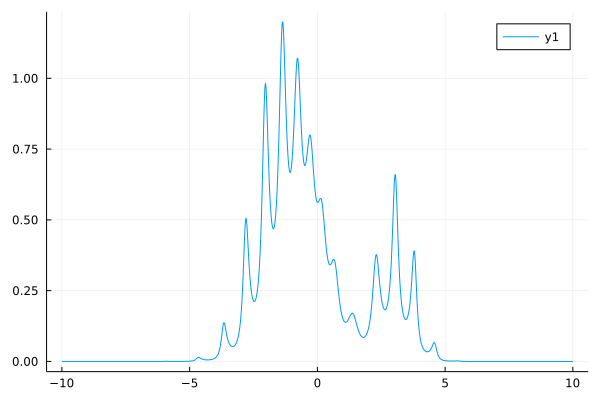

In [14]:
plot(real.(raw_reals.freq), imag.(raw_reals.val))
#plot!(omegas, rho.(omegas))

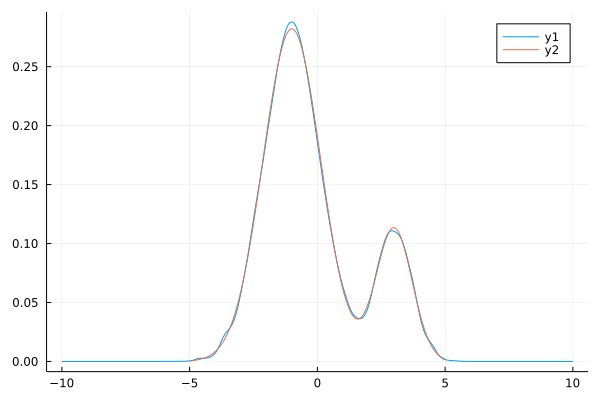

In [15]:
plot()
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [35]:
imaginary = Nevanlinna.ImagDomainData(test_smpl, test_gw, N_imag)
#noopt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#opt_raw_reals = Nevanlinna.RealDomainData(IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag], omega_max, eta, T=T)
#noopt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
#opt_raw_reals.freq .= Array{Complex{T}}(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]))*pi*im/beta
noopt_raw_reals = Nevanlinna.RealDomainData(2000, omega_max, eta, T=T)
opt_raw_reals = Nevanlinna.RealDomainData(2000, omega_max, eta, T=T)
noopt_raw_reals.freq .= ((collect(1:2000).-1000)/1000)*2*pi*im/beta
opt_raw_reals.freq .= ((collect(1:2000).-1000)/1000)*2*pi*im/beta
println(typeof(imaginary))
println(typeof(raw_reals))

phis = Nevanlinna.calc_phis(imaginary)
abcd = Nevanlinna.calc_abcd(imaginary, noopt_raw_reals, phis)
ab_coeff  = zeros(ComplexF64, 2*sol.H) 
hardy_matrix = Nevanlinna.calc_hardy_matrix(noopt_raw_reals, sol.H)

Nevanlinna.evaluation!(noopt_raw_reals, abcd, sol.H, ab_coeff, hardy_matrix)
Nevanlinna.evaluation!(opt_raw_reals, abcd, sol.H, sol.ab_coeff, hardy_matrix)

Pick matrix is positive semi-definite.
ImagDomainData{BigFloat}
RealDomainData{BigFloat}
max_theta=0.0
hardy optimization was success.
max_theta=667.882110958782285287747221012304969084822223609659545041596815768545928901909310383773278227361161780790536750133761224257924154406598503881816011113173166
hardy optimization was failure.


false

In [36]:
using FastGaussQuadrature
using OMEinsum
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end

function calc_green_z(z::Vector{ComplexF64}, xmin::Float64, xmax::Float64, deg::Int64)
    quad_rule = _gausslegendre(deg, xmin, xmax)
    newaxis = [CartesianIndex()]
    green_z = ein"q,q,wq->w"(
            quad_rule[2],
            rho.(quad_rule[1]),
            1 ./ (z[:, newaxis] .- quad_rule[1][newaxis, :])
        )
    return green_z
end
#exact_g = calc_green_z(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag])*im*pi/beta, -omega_max, omega_max, 1000)
exact_g = calc_green_z(((collect(1:2000).-1000)/1000)*2*pi*im/beta, -omega_max, omega_max, 10000)

;

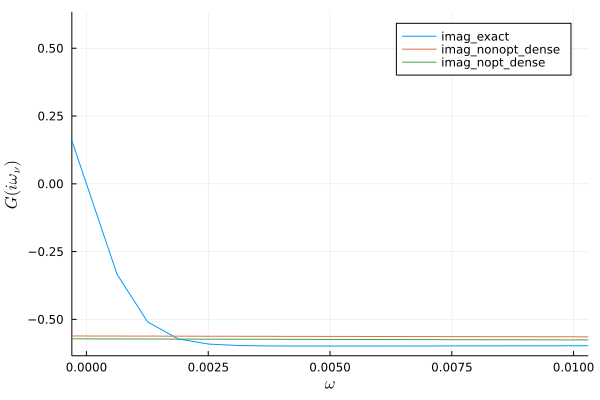

In [38]:
plot()
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(exact_g)), xlim=[0,0.3],label="real_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(((collect(1:200).-100)/100)*2*pi/beta, Float64.(real.(-opt_raw_reals.val)), label="real_nopt_dense")
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(imag.(exact_g)), xlim=[0,0.01],label="imag_exact", xlabel=latexstring("\\omega"), ylabel=latexstring("G(i\\omega_\\nu)"))
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(imag.(-opt_raw_reals.val)), label="imag_nopt_dense")

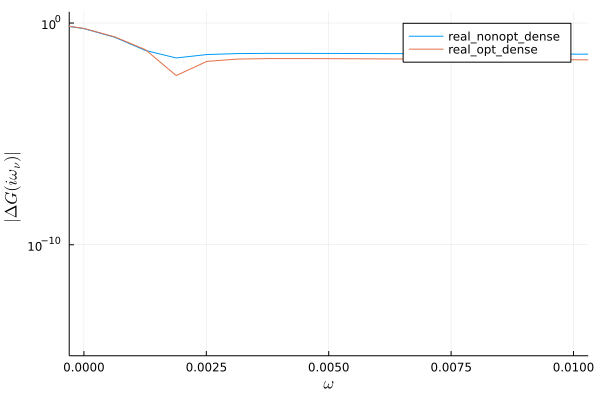

In [40]:
plot()
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-noopt_raw_reals.val-exact_g)), xlim = [0,0.01], label="real_nonopt_dense", xlabel=latexstring("\\omega"), ylabel=latexstring("|\\Delta G(i\\omega_\\nu)|"), yaxis=:log)
plot!(((collect(1:2000).-1000)/1000)*2*pi/beta, Float64.(abs.(-opt_raw_reals.val-exact_g)), label="real_opt_dense")

In [20]:
#plot()
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(exact_g)), label="real_exact", xlabel=latexstring("\\nu"), ylabel=latexstring("G(i\\omega_\\nu)"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-noopt_raw_reals.val)), label="real_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(real.(-opt_raw_reals.val)), label="real_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(real.(test_gw[1:N_imag])), label="real_sparse")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(exact_g)), label="imag_exact")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-noopt_raw_reals.val)), label="imag_nonopt_dense")
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(imag.(-opt_raw_reals.val)), label="imag_opt_dense")
#plot!(IR_basis_set.smpl_wn_f.sampling_points[hnw+1:hnw+N_imag], Float64.(imag.(test_gw[1:N_imag])), label="imag_sparse")

In [21]:
#plot()
#plot(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-noopt_raw_reals.val.-exact_g)), yaxis=:log, label="abs_nonopt_dense", xlabel=latexstring("\\nu"), ylabel=latexstring("\\Delta |G(i\\omega_\\nu)|"))
#plot!(collect(1:IR_basis_set.smpl_wn_f.sampling_points[hnw+N_imag]), Float64.(abs.(-opt_raw_reals.val-exact_g)), label="abs_opt_dense")

In [22]:
#=
mesh = 1024
myx = 40*(collect(1:mesh) .- mesh/2) ./ mesh
myy = 20*(collect(1:mesh) .- 1) ./ mesh
hardy_plot = Array{Complex{BigFloat}}(undef, mesh, mesh) 
for i in 1:mesh
    for j in 1:mesh
        hardy_plot[j,i] = hardy_basis(myx[j],myy[i],20)
    end
end
plt.figure(figsize=(3.7,1.5))
#plt.pcolormesh(myx, myy, real.(hardy_basis.(myx,myy,1)'), shading="auto")
plt.pcolormesh(myx, myy, Float64.(real.(hardy_plot')))
#plt.pcolormesh(myx, myy, Float64.(imag.(conj.(hardy_plot)')))
ax = plt.gca()
ax.set_xlim([-20,20])
ax.set_ylim([0,1])
#ax.set_aspect("equal")
plt.colorbar()
plt.show()
=#

In [23]:
#=
f = open( "in_green.dat", "w")
for iw in 1:hnw
    IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]
    omega = IR_basis_set.smpl_wn_f.sampling_points[hnw+iw]*pi/beta
    green = gw[hnw+iw]
    println(f, "$omega \t $(real(green)) \t $(imag(green))")
end
close(f)
g = open( "input.txt", "w")
    println(g,"in_green.dat \t $hnw \tout_spec.dat")
close(g)
=#
#=
f = open("in_green.dat", "r")
for i in 1:hnw
    list = readline(f)
    s  = split(list,'\t')
    o  = parse(BigFloat, s[1])
    re = parse(BigFloat, s[2])
    ii = parse(BigFloat, s[3])
    test_smpl[i] = o
    test_gw[i]   = re + ii*im
end
close(f)
=#